## Hands-on 12: Classificação de imagens (Flowers)

Baseado nesse artigo: https://towardsdatascience.com/flower-classification-with-convolutional-neural-networks-b97130329e5f

### Montando o drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Imports das bibliotecas

In [ ]:
!pip install keras

In [ ]:
import os
import cv2
import random
from os import listdir
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### Caminho do dataset

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/flowers'
categories = ['tulip', 'dandelion', 'daisy', 'rose', 'sunflower']

### Carregando o nome dos arquivos


In [ ]:
fnames = []
for category in categories:
    flower_folder = os.path.join(path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print(f'Tamanho para cada categoria: {[len(f) for f in fnames]}')

Tamanho para cada categoria: [984, 1055, 769, 784, 734]


### Carregando os arquivos

In [ ]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

print(f'Número de imagens para cada categoria: {[len(f) for f in fnames]}')

Número de imagens para cada categoria: [984, 1055, 769, 784, 734]


### Exemplo das imagens

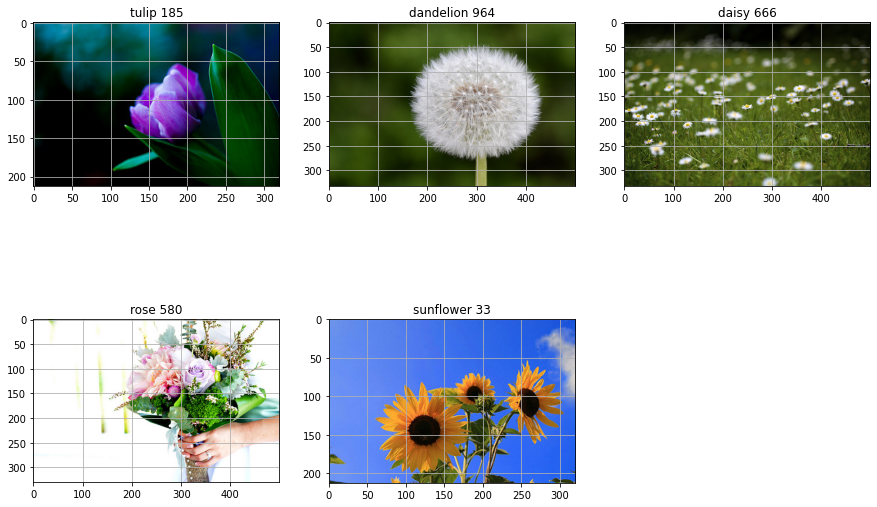

In [ ]:
plt.figure(figsize=(15, 10))

for i, imgs in enumerate(images):
    plt.subplot(2, 3, i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cv2.cvtColor(imgs[idx], cv2.COLOR_BGR2RGB))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

### Redimensionamento das imagens

In [ ]:
resized_images = []
img_width, img_height = 144, 144

for i, imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

### Separação dos dados


In [ ]:
from sklearn.model_selection import train_test_split

train_images = []
val_images = []

for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

### Gerando os rótulos

In [ ]:
len_train_images = [len(imgs) for imgs in train_images]
print('Soma das imagens de treino:', np.sum(len_train_images))

train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')

for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

Soma das imagens de treino: 3457


In [ ]:
len_val_images = [len(imgs) for imgs in val_images]
print('Soma das imagens de teste:', np.sum(len_val_images))

val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')

for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

Soma das imagens de teste: 866


### Converte os dados em matriz numpy

In [ ]:
tmp_train_imgs = []
tmp_val_imgs = []

for imgs in train_images:
    tmp_train_imgs += imgs

for imgs in val_images:
    tmp_val_imgs += imgs
    
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [ ]:
from tensorflow.python.keras.utils import np_utils

train_data = train_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))

val_data = val_images.astype('float32')
val_labels = np_utils.to_categorical(val_categories, len(categories))

print(f'Train data: {train_data.shape}')
print(f'Train labels: {train_labels.shape}')

Train data: (3457, 144, 144, 3)
Train labels: (3457, 5)


### Embaralhando a base de dados

In [ ]:
seed = 100
np.random.seed(seed)

np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

X_train = train_data[:3400]
y_train = train_labels[:3400]
X_test = val_data[:860]
y_test = val_labels[:860]

### Normalização dos dados

In [ ]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
X_train[0][0][:5]

array([[0.99215686, 0.99215686, 0.99215686],
       [0.96862745, 0.96862745, 0.96862745],
       [0.9529412 , 0.9529412 , 0.9529412 ],
       [0.9647059 , 0.9647059 , 0.9647059 ],
       [0.9607843 , 0.9607843 , 0.9607843 ]], dtype=float32)

### Implementação da Rede

In [ ]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.python.keras.models import Model

### VGG19

In [ ]:
model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

for layer in model.layers[:1]:
  layer.trainable=False
      
x = model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
    
final_model = Model(inputs=model.input, outputs=predictions)
final_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
final_model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 144, 144, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 144, 144, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 144, 144, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 72, 72, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 72, 72, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 72, 72, 128)       147584    
_______________________________________________________

### ResNet50

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model.layers[0].trainable=False
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________

### Data Augmentation


In [ ]:
batch_size = 128
epochs = 50

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.06, 
    shear_range=0.9,
    height_shift_range=0.3, 
    zoom_range=0.3
)

train_gen.fit(X_train)
train_generator = train_gen.flow(X_train, y_train, batch_size=batch_size)
print('Number of examples:', train_generator.n)

Number of examples: 3400


In [ ]:
test_gen = ImageDataGenerator()
test_generator = test_gen.flow(X_test, y_test, batch_size=batch_size)

### Modelos


In [ ]:
from keras.callbacks import TensorBoard, EarlyStopping
%load_ext tensorboard
tbCallBack = TensorBoard(log_dir='logs_lab09', histogram_freq=0, write_graph=True, write_images=True)

#### VGG19

In [ ]:
import time
start = time.time()

model_vgg19 = final_model.fit(train_generator,
                      steps_per_epoch= X_train.shape[0]//batch_size, 
                      epochs = epochs,
                      validation_data=test_generator, 
                      validation_steps=y_test.shape[0]//batch_size,
                      callbacks=[EarlyStopping(patience=3),tbCallBack])

end = time.time()
print(f'Duração em minutos: {(end - start)/60}')

Epoch 1/50
 1/26 [>.............................] - ETA: 0s - loss: 1.7854 - accuracy: 0.2031WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 27s 1s/step - loss: 1.7115 - accuracy: 0.2372 - val_loss: 1.6335 - val_accuracy: 0.2617
Epoch 2/50
26/26 [==============================] - 24s 915ms/step - loss: 1.4616 - accuracy: 0.3493 - val_loss: 1.2628 - val_accuracy: 0.4336
Epoch 3/50
26/26 [==============================] - 24s 918ms/step - loss: 1.3255 - accuracy: 0.4166 - val_loss: 1.2003 - val_accuracy: 0.4727
Epoch 4/50
26/26 [==============================] - 24s 915ms/step - loss: 1.2660 - accuracy: 0.4432 - val_loss: 1.2317 - val_accuracy: 0.4271
Epoch 5/50
26/26 [==============================] - 24s 924ms/step - lo

In [ ]:
score = final_model.evaluate(X_test, y_test, verbose=1)
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

27/27 [==============================] - 3s 97ms/step - loss: 0.9950 - accuracy: 0.5965

Test loss: 0.994971752166748
Test accuracy: 0.5965116024017334


#### ResNet-50

In [ ]:
start = time.time()

model_resNet50 = model.fit(train_generator,
                      steps_per_epoch= X_train.shape[0]//batch_size, 
                      epochs = epochs,
                      validation_data=test_generator, 
                      validation_steps=y_test.shape[0]//batch_size,
                      callbacks=[EarlyStopping(patience=3),tbCallBack])

end = time.time()
print(f'Duração em minutos: {(end - start)/60}')

Epoch 1/50
26/26 [==============================] - 17s 652ms/step - loss: 1.6600 - accuracy: 0.3750 - val_loss: 1.5774 - val_accuracy: 0.2135
Epoch 2/50
26/26 [==============================] - 16s 623ms/step - loss: 1.3405 - accuracy: 0.4606 - val_loss: 1.5547 - val_accuracy: 0.3281
Epoch 3/50
26/26 [==============================] - 16s 625ms/step - loss: 1.2581 - accuracy: 0.5063 - val_loss: 1.5099 - val_accuracy: 0.3542
Epoch 4/50
26/26 [==============================] - 16s 616ms/step - loss: 1.2117 - accuracy: 0.5220 - val_loss: 1.5752 - val_accuracy: 0.3008
Epoch 5/50
26/26 [==============================] - 16s 623ms/step - loss: 1.1937 - accuracy: 0.5204 - val_loss: 1.5363 - val_accuracy: 0.3138
Epoch 6/50
26/26 [==============================] - 16s 617ms/step - loss: 1.1657 - accuracy: 0.5343 - val_loss: 1.4542 - val_accuracy: 0.3698
Epoch 7/50
26/26 [==============================] - 16s 605ms/step - loss: 1.1210 - accuracy: 0.5541 - val_loss: 1.4891 - val_accuracy: 0.2904

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

27/27 [==============================] - 2s 57ms/step - loss: 1.2156 - accuracy: 0.5163

Test loss: 1.215555191040039
Test accuracy: 0.5162790417671204


### Performance - Melhor modelo

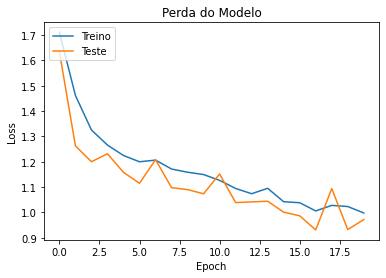

In [ ]:
plt.plot(model_vgg19.history['loss'])
plt.plot(model_vgg19.history['val_loss'])
plt.title('Perda do Modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'upper left')
plt.show()

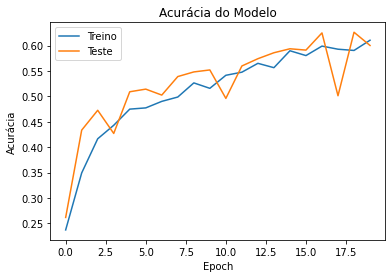

In [ ]:
plt.plot(model_vgg19.history['accuracy'])
plt.plot(model_vgg19.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'upper left')
plt.show()

### Predição

In [ ]:
pred = final_model.predict(X_test)

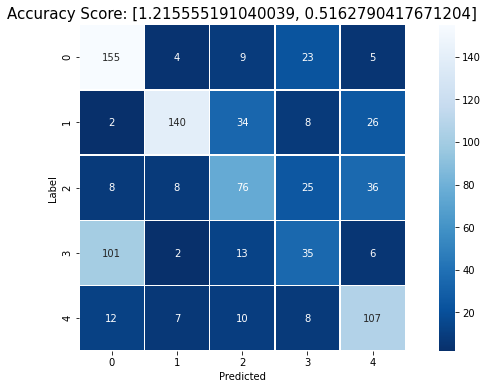

In [ ]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Label');
plt.xlabel('Predicted');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Salva o modelo

In [ ]:
final_model.save('/content/gdrive/My Drive/Colab Notebooks/modelo_lab12.h5')

### Resultado

In [ ]:
import pandas as pd

dic = {
    'model' : ['VGG19', 'ResNet-50'], 
    'time (min)': [8.68, 5.34],
    'accuracy': [0.596, 0.516]
}

res = pd.DataFrame(data=dic)
res.sort_values(['accuracy'], ascending=False)

,model,time (min),accuracy
0,VGG19,8.68,0.596
1,ResNet-50,5.34,0.516
